# Imports and define expectation func

In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent); os.chdir(set_path)

In [2]:
import torch
import matplotlib.pyplot as plt
from FittedModels.utils import plot_distributions, plot_samples
torch.manual_seed(5)
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from TargetDistributions.MoG import MoG
from TargetDistributions.Guassian_FullCov import Guassian_FullCov
from FittedModels.Models.DiagonalGaussian import DiagonalGaussian
from FittedModels.utils import plot_distributions
from FittedModels.train import LearntDistributionManager
from Utils import plot_func2D, MC_estimate_true_expectation, plot_distribution, expectation_function
from FittedModels.Models.FlowModel import FlowModel
from FittedModels.experimental.train_AIS import AIS_trainer
from FittedModels.utils import plot_history
import matplotlib.pyplot as plt
import torch
from TargetDistributions.MoG import MoG

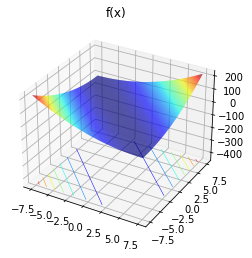

In [3]:
# setup expectation function
def expectation_function(x):
    A = torch.ones((x.shape[-1], x.shape[-1]))
    return torch.einsum("bi,ij,bj->b", x, A, x)
expectation_func_fig = plot_func2D(expectation_function, n_points=200, range=15)

# Let's start with Guassian Problem


Shows basic flow model is working (IAF clearly very expressive), if we use a friendly gaussian relatively well suited to the pior <br>
We see here that KL and DReG get very similar results

## Setup

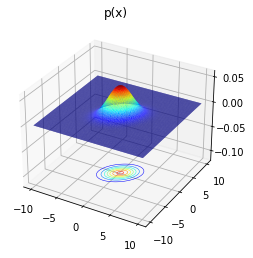

In [4]:
torch.manual_seed(2)
dim = 2
n_samples_estimation = int(1e4)
target = Guassian_FullCov(dim=dim, scale_covariance=1)
fig = plot_distribution(target)

In [5]:
true_expectation = MC_estimate_true_expectation(target, expectation_function, int(1e6))
true_expectation

tensor(8.2108)

## Flow with DReG - well suited prior

In [10]:
epochs = 10000
batch_size = 100

In [7]:
torch.manual_seed(0)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3, prior_scaling=1, flow_type="RealNVP")
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG")
expectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

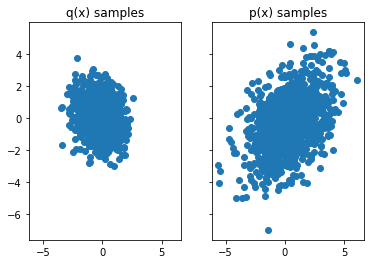

In [8]:
samples_fig_before = plot_samples(tester)

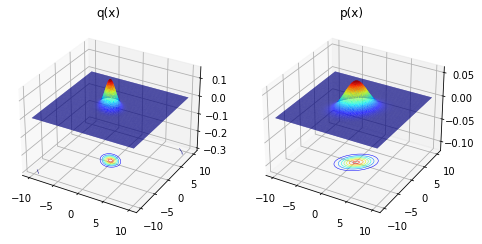

In [9]:
fig_before_train = plot_distributions(tester)

In [10]:
history = tester.train(epochs, batch_size=batch_size)
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size is {info['effective_sample_size']} \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

loss: -0.00014944924623705447, mean log p_x -3.8239150047302246: 100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [01:24<00:00, 118.05it/s]

estimate before training is 7.371506214141846 
estimate after training is 8.139599800109863 
effective sample size is 9999.6572265625 
variance in weights is 3.460664101204852e-13


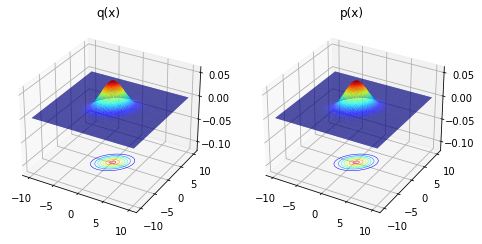

In [11]:
fig_after_train = plot_distributions(tester)

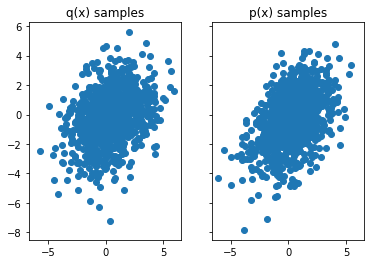

In [12]:
samples_fig_after = plot_samples(tester)

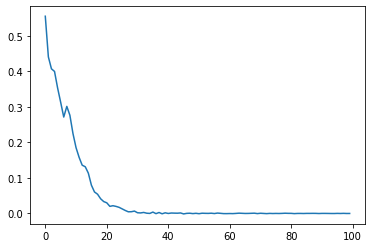

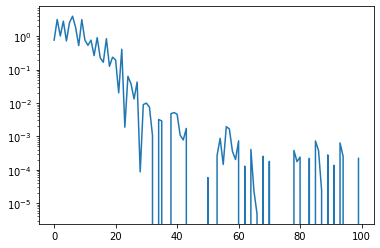

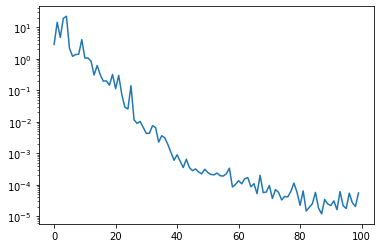

In [13]:
plt.figure()
plt.plot(history["kl"])
plt.figure()
plt.plot(history["alpha_2_divergence"])
plt.yscale("log")
plt.figure()
plt.plot(history["importance_weights_var"])
plt.yscale("log")

(<Figure size 432x720 with 8 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>,
        <AxesSubplot:title={'center':'kl'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence_over_p'}>,
        <AxesSubplot:title={'center':'importance_weights_var'}>,
        <AxesSubplot:title={'center':'normalised_importance_weights_var'}>],
       dtype=object))

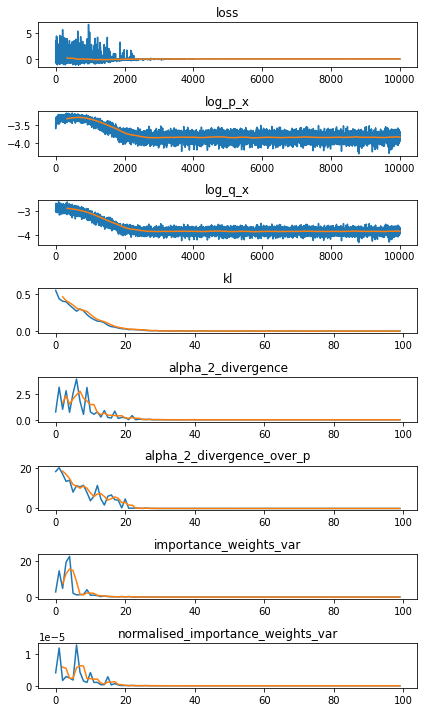

In [14]:
plot_history(history)

## Flow with MC alpha div
does terribly

In [40]:
epochs = 10
batch_size = 100

In [41]:
torch.manual_seed(0)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="alpha_MC", alpha=2)
expectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

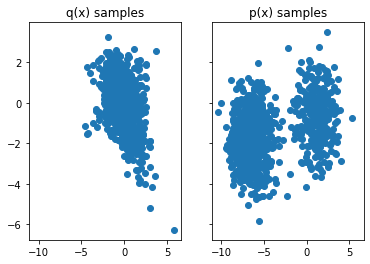

In [42]:
samples_fig_before = plot_samples(tester)

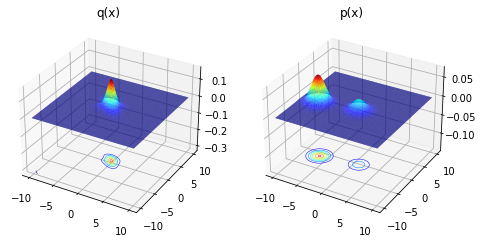

In [43]:
fig_before_train = plot_distributions(tester)

In [44]:
history = tester.train(epochs, batch_size=batch_size)
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size is {info['effective_sample_size']} \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

loss: -4.021877288818359, mean log p_x -5.010601997375488: 100%|███████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 15.85it/s]

estimate before training is 57.23211669921875 
estimate after training is 9.737849235534668 
effective sample size is 97.19760131835938 
variance in weights is 1.0189337444899138e-06


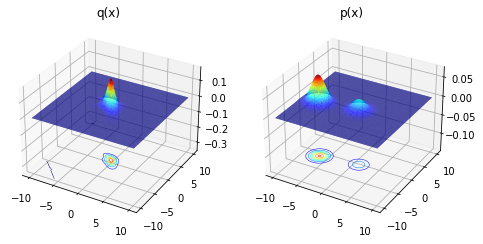

In [45]:
fig_after_train = plot_distributions(tester)

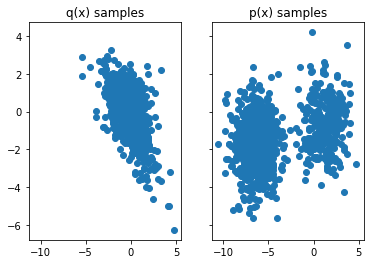

In [46]:
samples_fig_after = plot_samples(tester)

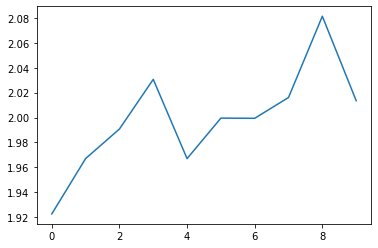

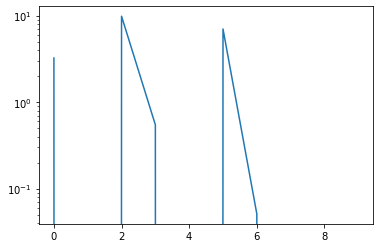

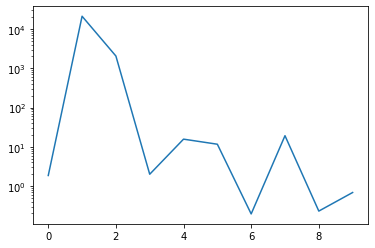

In [47]:
plt.figure()
plt.plot(history["kl"])
plt.figure()
plt.plot(history["alpha_2_divergence"])
plt.yscale("log")
plt.figure()
plt.plot(history["importance_weights_var"])
plt.yscale("log")

(<Figure size 432x720 with 8 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>,
        <AxesSubplot:title={'center':'kl'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence_over_p'}>,
        <AxesSubplot:title={'center':'importance_weights_var'}>,
        <AxesSubplot:title={'center':'normalised_importance_weights_var'}>],
       dtype=object))

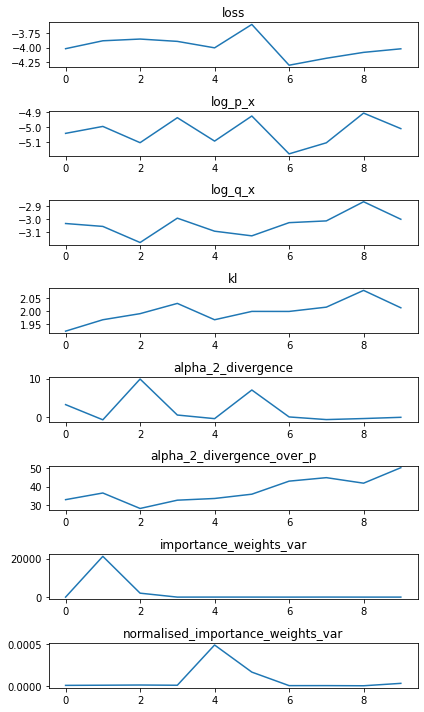

In [48]:
plot_history(history)

## Flow with KL - nice prior

In [11]:
epochs = 10000
batch_size = 100

In [12]:
torch.manual_seed(0)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="kl")
expectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

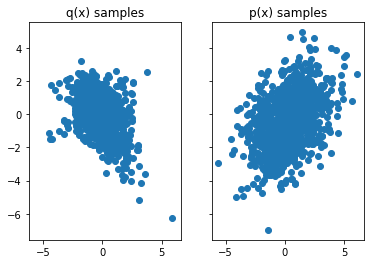

In [13]:
samples_fig_before = plot_samples(tester)

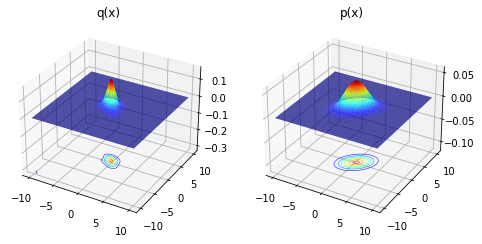

In [14]:
fig_before_train = plot_distributions(tester)

In [15]:
history = tester.train(epochs, batch_size=batch_size)

loss: -0.008387045934796333, mean log p_x -3.846059560775757: 100%|██████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:11<00:00, 76.31it/s]


NameError: name 'expectation' is not defined

In [19]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)
print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size is {info['effective_sample_size']} \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

estimate before training is 10.93683910369873 
estimate after training is 8.141221046447754 
effective sample size is 9981.8251953125 
variance in weights is 1.821078704500323e-11


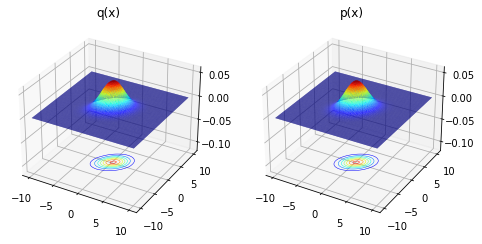

In [16]:
fig_after_train = plot_distributions(tester)

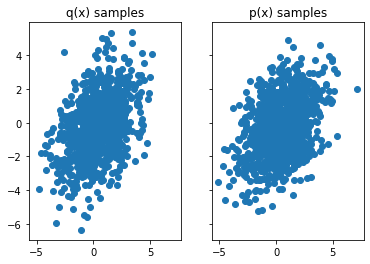

In [17]:
samples_fig_after = plot_samples(tester)

(<Figure size 432x720 with 8 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>,
        <AxesSubplot:title={'center':'kl'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence_over_p'}>,
        <AxesSubplot:title={'center':'importance_weights_var'}>,
        <AxesSubplot:title={'center':'normalised_importance_weights_var'}>],
       dtype=object))

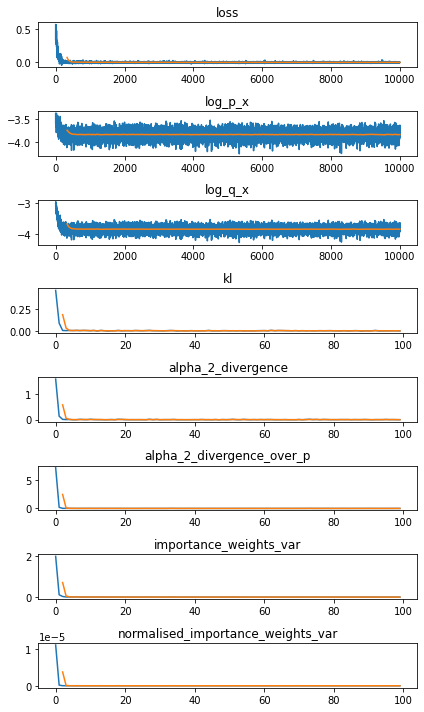

In [18]:
plot_history(history)

## Setup nastier prior

In [ ]:
torch.manual_seed(2)
dim = 2
n_samples_estimation = int(1e4)
target = Guassian_FullCov(dim=dim, scale_covariance=0.01)
fig = plot_distribution(target)

## Flow with DReG - poorly suited prior

In [ ]:
torch.manual_seed(0)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3, prior_scaling=1)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG")
#expectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

In [ ]:
fig_before_train = plot_distributions(tester)

In [ ]:
samples_fig_before = plot_samples(tester)

In [ ]:
history = tester.train(epochs, batch_size=batch_size)
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"effective sample size is {info['effective_sample_size']} \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

In [ ]:
samples_fig_after = plot_samples(tester)

In [ ]:
fig_after_train = plot_distributions(tester, bounds = [[-2, 2],[-2, 2]])

In [ ]:
plot_history(history)

## Flow with kl - poorly suited prior

In [ ]:
torch.manual_seed(0) 
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="kl")
expectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

In [ ]:
dist_before = plot_distributions(tester)
# below plot if we want to look in specific zone
#flow_only = plot_distribution(tester.learnt_sampling_dist, bounds = [[-100, 0],[-10, 10]], n_points=200)

In [ ]:
samples_fig_before = plot_samples(tester)

In [ ]:
history = tester.train(epochs, batch_size=batch_size)

expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"effective sample size is {info['effective_sample_size']} \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")


In [ ]:
samples_fig_after = plot_samples(tester)

In [ ]:
fig_after_train = plot_distributions(tester)

In [ ]:
plot_history(history)

## Let's compare to our standard diagonal guassian case to show that flows help

In [ ]:
learnt_sampler = DiagonalGaussian(dim=dim)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG")
fig_before = fig_before_train = plot_distributions(tester)
expectation_before, sampling_weights_before = tester.estimate_expectation()

In [ ]:
history = tester.train(epochs)
expectation, info = tester.estimate_expectation(n_samples_estimation)
true_expectation = torch.sum(tester.target_dist.mean)

print(f"true expectation is {true_expectation} \n"
      f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size is {info['effective_sample_size']} \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")
fig_after_train = plot_distributions(tester)

# Now let's do some MoG

## Setup

In [4]:
from TargetDistributions.base import BaseTargetDistribution

class custom_MoG(torch.distributions.MixtureSameFamily, BaseTargetDistribution):
    def __init__(self, dim=2, loc_scaling=1, cov_scaling=1):
        self.dim = dim
        distributions = []
        locs = []
        covs = []
        locs_ = [-1, 1]
        for i in range(2):
            loc = torch.ones(dim)*locs_[i]*loc_scaling
            covariance = torch.eye(dim)*cov_scaling
            locs.append(loc[None, :])
            covs.append(covariance[None, :, :])
        locs = torch.cat(locs)
        covs = torch.cat(covs)
        mix = torch.distributions.Categorical(torch.tensor([0.6, 0.4]))
        com = torch.distributions.MultivariateNormal(locs, covs)
        super(custom_MoG, self).__init__(mixture_distribution = mix, component_distribution = com)

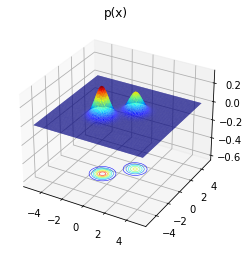

In [5]:
torch.manual_seed(6)
epochs = 500
dim = 2
n_samples_estimation = int(1e4)
#target = MoG(dim=dim, n_mixes=2, min_cov=0.01, loc_scaling=0.8)
target = custom_MoG(dim=dim, cov_scaling=0.3)
fig = plot_distribution(target, bounds=[[-5, 5], [-5, 5]])

## DReG

In [66]:
torch.manual_seed(0)
learnt_sampler = FlowModel(x_dim=dim , n_flow_steps=3) #, flow_type="RealNVP")
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG", k=None)

In [67]:
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

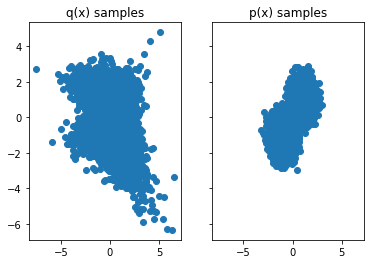

In [68]:
samples_before = plot_samples(tester, n_samples=int(1e4))

In [69]:
history = tester.train(1000, batch_size=int(1e2))

loss: -0.07721869647502899, mean log p_x -2.4676921367645264: 100%|████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 31.24it/s]


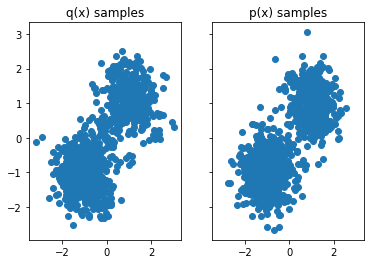

In [70]:
samples_fig_after = plot_samples(tester)

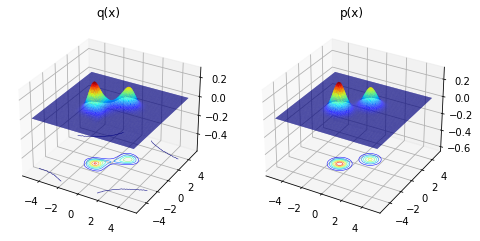

In [71]:
fig_after_train = plot_distributions(tester, bounds=[[-5, 5], [-5, 5]])

In [72]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']} \n"
     f"effective sample size after train is {info['effective_sample_size']} \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

estimate before training is 4.562889099121094 
estimate after training is 4.583701133728027 
effective sample size before is 1849.11865234375 
effective sample size after train is 9193.6328125 
variance in weights is 8.771827708642377e-10


(<Figure size 432x720 with 8 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>,
        <AxesSubplot:title={'center':'kl'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence_over_p'}>,
        <AxesSubplot:title={'center':'importance_weights_var'}>,
        <AxesSubplot:title={'center':'normalised_importance_weights_var'}>],
       dtype=object))

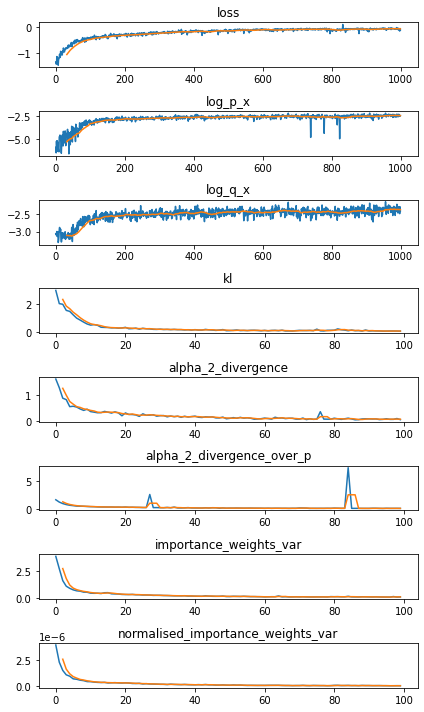

In [73]:
plot_history(history)

## kl

In [74]:
torch.manual_seed(0) # 0
learnt_sampler = FlowModel(x_dim=dim , n_flow_steps=3) #, flow_type="RealNVP")
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="kl") 
expectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

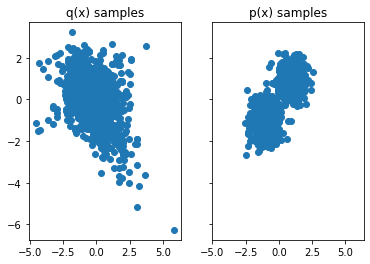

In [75]:
samples_before = plot_samples(tester)

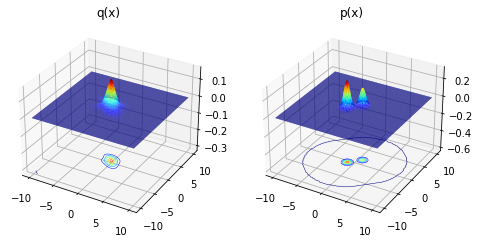

In [76]:
fig_before_train = plot_distributions(tester)

In [77]:
history = tester.train(1000, batch_size=100) # epochs 1000

loss: 0.11185682564973831, mean log p_x -2.554006338119507: 100%|██████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 59.43it/s]


In [78]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
      f"effective sample size before is {info_before['effective_sample_size']} out of {n_samples_estimation} \n"
     f"effective sample size after is {info['effective_sample_size']} out of {n_samples_estimation}  \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

estimate before training is 4.562889099121094 
estimate after training is 4.592784404754639 
effective sample size before is 1849.11865234375 out of 10000 
effective sample size after is 9075.310546875 out of 10000  
variance in weights is 1.0190099875018177e-09


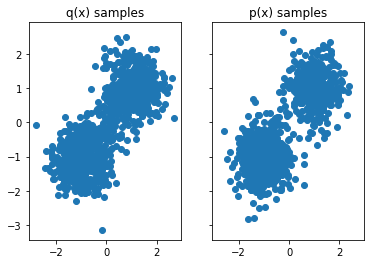

In [79]:
samples_after = plot_samples(tester)

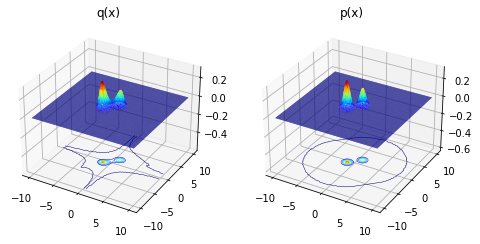

In [80]:
fig_after_train = plot_distributions(tester)

(<Figure size 432x720 with 8 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>,
        <AxesSubplot:title={'center':'kl'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence_over_p'}>,
        <AxesSubplot:title={'center':'importance_weights_var'}>,
        <AxesSubplot:title={'center':'normalised_importance_weights_var'}>],
       dtype=object))

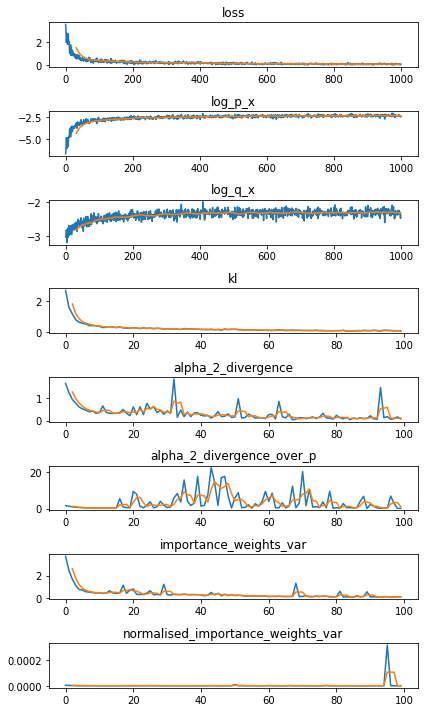

In [81]:
plot_history(history)

## DReG with alpha = 0.05

In [77]:
torch.manual_seed(0) # 1 we get a pathological case
learnt_sampler = FlowModel(x_dim=dim , n_flow_steps=5) #  , flow_type="RealNVP"
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG", alpha=0.05) # "kl"

In [78]:
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

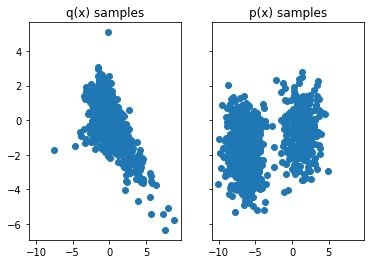

In [79]:
samples_before = plot_samples(tester)

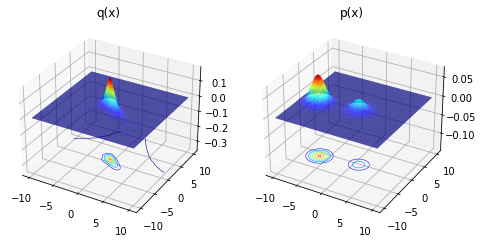

In [80]:
fig_before_train = plot_distributions(tester)

In [81]:
history = tester.train(10000, batch_size=100)

loss: 0.0023355912417173386, mean log p_x -3.956050157546997: 100%|██████████████████████████████████████████████████████████████████████████████| 10000/10000 [06:31<00:00, 25.54it/s]


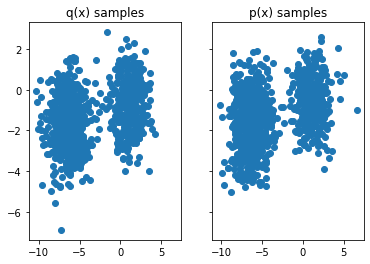

In [82]:
samples_fig_after = plot_samples(tester)

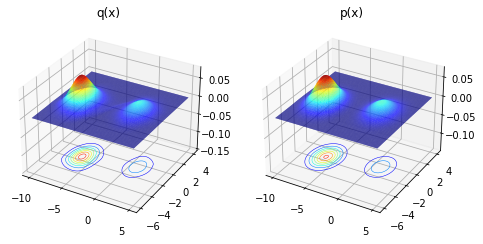

In [83]:
fig_after_train = plot_distributions(tester, bounds=[[-10, 5], [-6, 4]])

In [84]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']} \n"
     f"effective sample size after train is {info['effective_sample_size']} \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

estimate before training is 73.07716369628906 
estimate after training is 49.24192428588867 
effective sample size before is 3.1710779666900635 
effective sample size after train is 9448.462890625 
variance in weights is 5.837889616167047e-10


(<Figure size 432x720 with 8 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>,
        <AxesSubplot:title={'center':'kl'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence_over_p'}>,
        <AxesSubplot:title={'center':'importance_weights_var'}>,
        <AxesSubplot:title={'center':'normalised_importance_weights_var'}>],
       dtype=object))

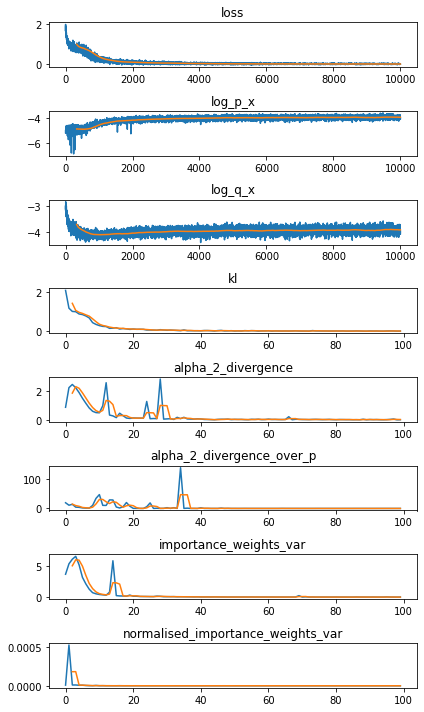

In [85]:
plot_history(history)

# Difficult MoG

## Setup

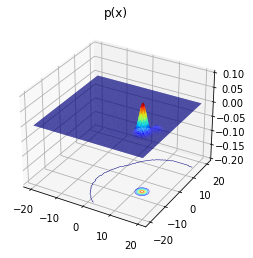

In [55]:
torch.manual_seed(0)
epochs = 500
dim = 2
n_samples_estimation = int(1e4)
target = MoG(dim=dim, n_mixes=2, min_cov=1, loc_scaling=10)
fig = plot_distribution(target, bounds=[[-20, 20], [-20, 20]])

## DReG

In [39]:
torch.manual_seed(1) 
learnt_sampler = FlowModel(x_dim=dim , n_flow_steps=3, flow_type="RealNVP")
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG")#, alpha=0.05) # "kl"

In [40]:
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

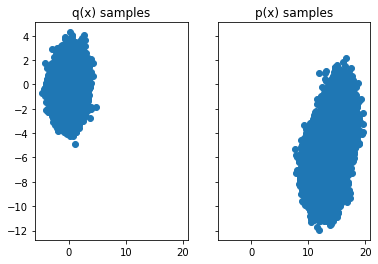

In [41]:
samples_before = plot_samples(tester, n_samples=int(1e5))

In [42]:
history = tester.train(300, batch_size=int(1e3))

loss: -556.09130859375, mean log p_x -147.71902465820312: 100%|██████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:06<00:00, 45.08it/s]


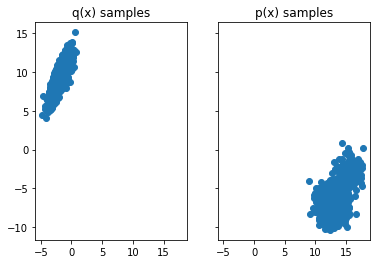

In [43]:
samples_fig_after = plot_samples(tester)

Text(0.5, 1.0, 'MC estimate of log alpha divergence (alpha=2) using p(x) to sample')

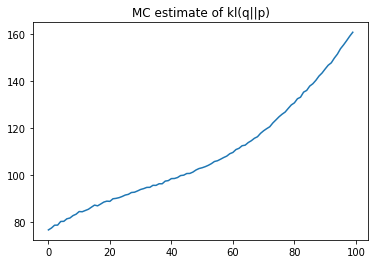

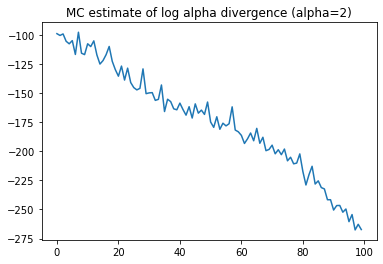

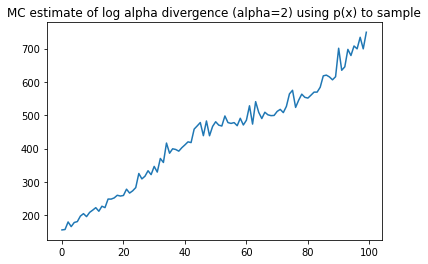

In [49]:
plt.figure()
plt.plot(history["kl"])
plt.title("MC estimate of kl(q||p)")
plt.figure()
plt.plot(history["alpha_2_divergence"])
#plt.yscale("log")
plt.title("MC estimate of log alpha divergence (alpha=2)")
plt.figure()
plt.plot(history["alpha_2_divergence_over_p"])
#plt.yscale("log")
plt.title("MC estimate of log alpha divergence (alpha=2) using p(x) to sample")

Text(0.5, 1.0, 'normalised importance weights variance')

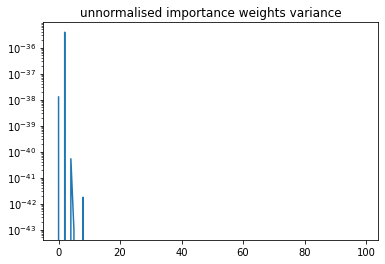

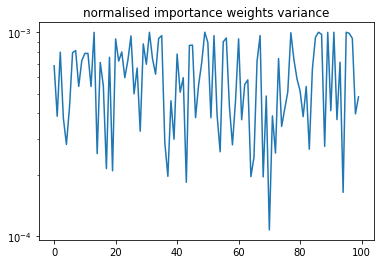

In [45]:
plt.figure()
plt.plot(history["importance_weights_var"])
plt.yscale("log")
plt.title("unnormalised importance weights variance")
plt.figure()
plt.plot(history["normalised_importance_weights_var"])
plt.yscale("log")
plt.title("normalised importance weights variance")

(<Figure size 432x720 with 8 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>,
        <AxesSubplot:title={'center':'kl'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence_over_p'}>,
        <AxesSubplot:title={'center':'importance_weights_var'}>,
        <AxesSubplot:title={'center':'normalised_importance_weights_var'}>],
       dtype=object))

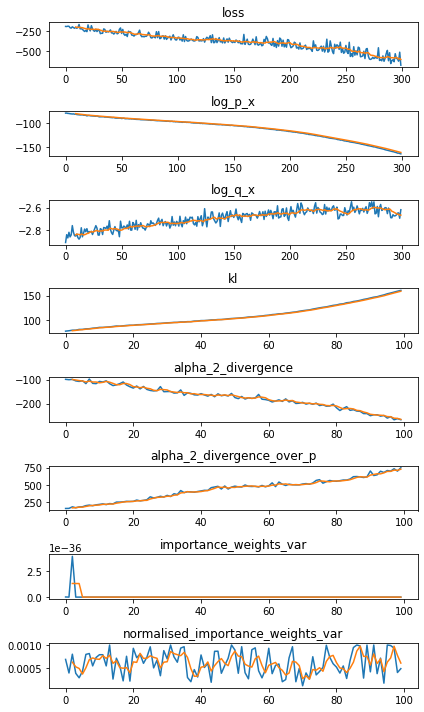

In [46]:
plot_history(history)

In [47]:
#fig_after_train = plot_distributions(tester)

In [48]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']} \n"
     f"effective sample size after train is {info['effective_sample_size']} \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

estimate before training is 2.2595129013061523 
estimate after training is 11.35754680633545 
effective sample size before is 1.0027508735656738 
effective sample size after train is 1.6206051111221313 
variance in weights is 6.170151027617976e-05


## kl

In [44]:
torch.manual_seed(1) # 0
learnt_sampler = FlowModel(x_dim=dim , n_flow_steps=3) # , flow_type="RealNVP"
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="kl") 
expectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

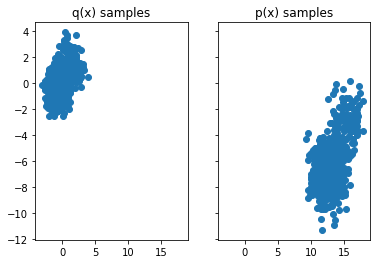

In [45]:
samples_before = plot_samples(tester)

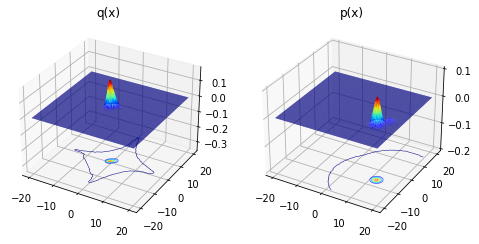

In [46]:
fig_before_train = plot_distributions(tester, bounds=[[-20, 20], [-20, 20]])

In [47]:
history = tester.train(1000, batch_size=100) # epochs 1000

loss: 57.62255859375, mean log p_x -61.090545654296875:  15%|█████████████                                                                          | 150/1000 [00:02<00:14, 57.42it/s]


ValueError: The value argument must be within the support

In [48]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size is {info['effective_sample_size']} \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

estimate before training is 14.516969680786133 
estimate after training is 269.3033447265625 
effective sample size is 26.173866271972656 
variance in weights is 3.8109860724944156e-06


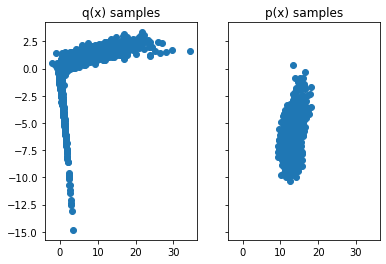

In [49]:
samples_after = plot_samples(tester)

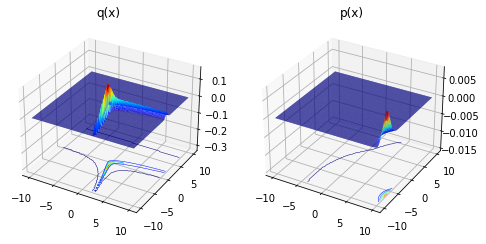

In [50]:
fig_after_train = plot_distributions(tester, )

(<Figure size 432x720 with 8 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>,
        <AxesSubplot:title={'center':'kl'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence_over_p'}>,
        <AxesSubplot:title={'center':'importance_weights_var'}>,
        <AxesSubplot:title={'center':'normalised_importance_weights_var'}>],
       dtype=object))

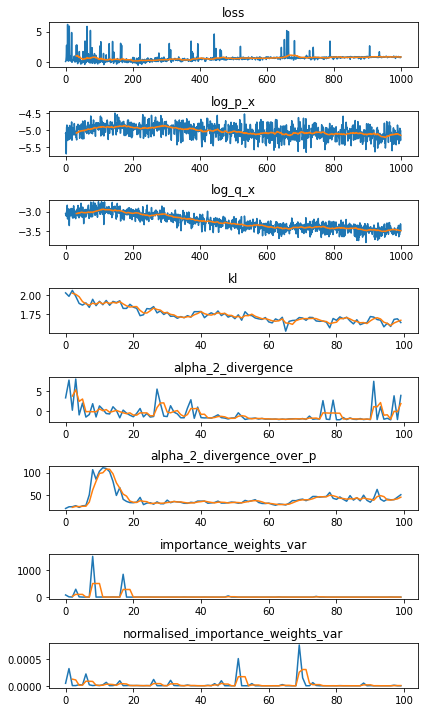

In [51]:
plot_history(history)

##  Lumpy

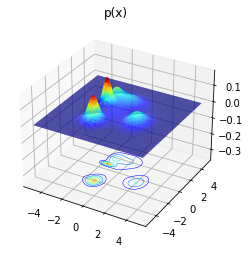

In [41]:
torch.manual_seed(0)
dim = 2
n_samples_estimation = int(1e4)
target = MoG(dim=dim, n_mixes=10, min_cov=0, loc_scaling=1.5)
fig = plot_distribution(target, bounds=[[-5, 5], [-5, 5]])

In [51]:
torch.manual_seed(0)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3, prior_scaling=1)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG")
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

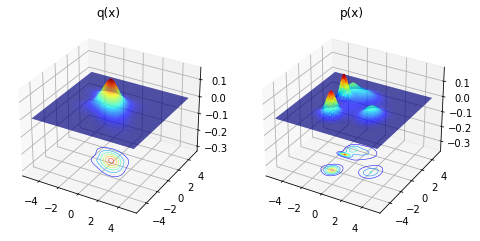

In [52]:
fig_before_train = plot_distributions(tester, bounds=[[-5, 5], [-5, 5]])

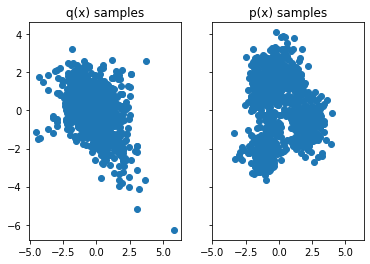

In [53]:
samples_fig_before = plot_samples(tester)

In [57]:
history = tester.train(5000, batch_size=int(1e4))
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

loss: -1.0833160877227783, mean log p_x -5.196523666381836: 100%|██████████████████████████████████████████████████████████████████████████████████| 5000/5000 [12:14<00:00,  6.81it/s]


In [58]:
print(f"effective sample size before is {info_before['effective_sample_size']} \n"
     f"effective sample size after train is {info['effective_sample_size']} \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

effective sample size before is 531.2528686523438 
effective sample size after train is 4691.548828125 
variance in weights is 1.1316046766296495e-08


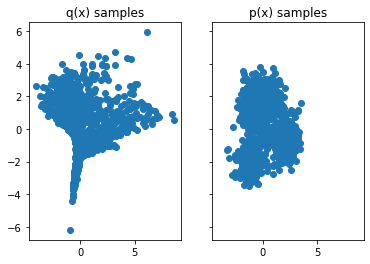

In [59]:
samples_fig_after = plot_samples(tester)

In [60]:
#fig_after_train = plot_distributions(tester, bounds=[[-5, 5], [-5, 5]])

NaN encountered in alpha_2_divergence_over_p history


(<Figure size 432x720 with 8 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>,
        <AxesSubplot:title={'center':'kl'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence_over_p'}>,
        <AxesSubplot:title={'center':'importance_weights_var'}>,
        <AxesSubplot:title={'center':'normalised_importance_weights_var'}>],
       dtype=object))

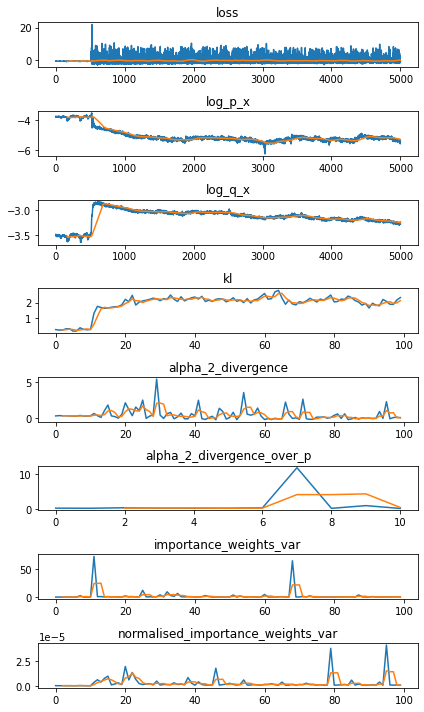

In [61]:
plot_history(history)

## KL

In [138]:
torch.manual_seed(0)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3, prior_scaling=1)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="kl")
#expectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

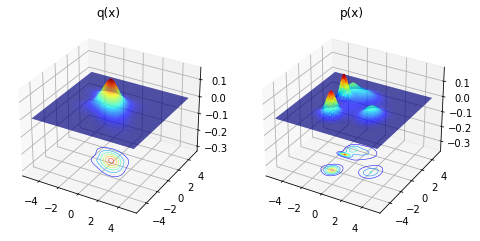

In [139]:
fig_before_train = plot_distributions(tester, bounds=[[-5, 5], [-5, 5]])

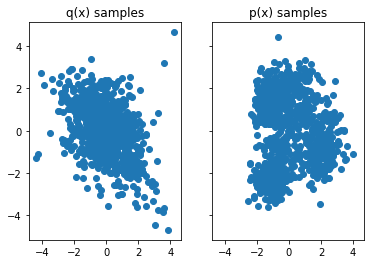

In [140]:
samples_fig_before = plot_samples(tester)

In [141]:
history = tester.train(10000, batch_size=100)
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

loss: 0.0703321248292923, mean log p_x -3.4711873531341553: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:45<00:00, 95.13it/s]


In [142]:
print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']} \n"
     f"effective sample size after train is {info['effective_sample_size']} \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

estimate before training is 4.562889099121094 
estimate after training is 5.150981426239014 
effective sample size before is 1849.11865234375 
effective sample size after train is 8080.39794921875 
variance in weights is 2.3758612854862804e-09


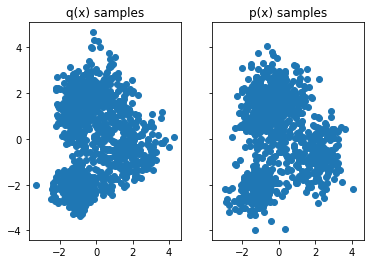

In [143]:
samples_fig_after = plot_samples(tester)

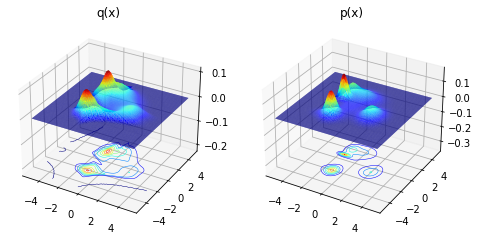

In [144]:
fig_after_train = plot_distributions(tester, bounds=[[-5, 5], [-5, 5]])

(<Figure size 432x720 with 8 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>,
        <AxesSubplot:title={'center':'kl'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence'}>,
        <AxesSubplot:title={'center':'alpha_2_divergence_over_p'}>,
        <AxesSubplot:title={'center':'importance_weights_var'}>,
        <AxesSubplot:title={'center':'normalised_importance_weights_var'}>],
       dtype=object))

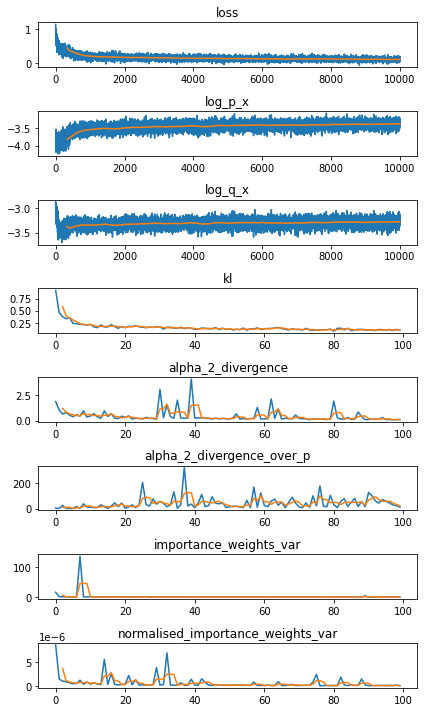

In [145]:
plot_history(history)

## AIS + DreG

In [ ]:
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=5) #, flow_type="RealNVP")
#tester = AIS_trainer(target, learnt_sampler, loss_type="DReG", n_distributions=3, n_updates_Metropolis=20)
tester = AIS_trainer(target, learnt_sampler, loss_type="DReG", n_distributions=3, n_updates_Metropolis=5)

In [ ]:
samples_before = plot_samples(tester)

In [ ]:
fig_before = plot_distributions(tester)

In [ ]:
history = tester.train(200, batch_size=500)

In [ ]:
samples_after = plot_samples(tester)

In [ ]:
fig = plot_distributions(tester)

In [ ]:
history = tester.train(1000, batch_size=400)

In [ ]:
fig = plot_distributions(tester, range=10)

In [ ]:
plot_history(history)

# More Experiments

## Let's add extra noise to x
my hypothesis is that this should help
 - the result is that it prevents the distribution from collapsing, but the distribution still struggles (I suppose adding noise also breaks the objective function, as expectation no longer over q(x)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from FittedModels.Models.base import BaseLearntDistribution
Notebook = True
if Notebook:
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

class LearntDistributionManager:
    def __init__(self, target_distribution, fitted_model, importance_sampler,
                 loss_type="kl", alpha=2):
        self.importance_sampler = importance_sampler
        self.learnt_sampling_dist: BaseLearntDistribution
        self.learnt_sampling_dist = fitted_model
        self.target_dist = target_distribution
        self.optimizer = torch.optim.Adam(self.learnt_sampling_dist.parameters(), lr=1e-3)
        self.loss_type = loss_type
        self.noise_scaling_factor = 1
        if loss_type == "kl":
            self.loss = self.KL_loss
            self.alpha = 1
        elif loss_type == "DReG":
            self.loss = self.dreg_alpha_divergence_loss
            self.alpha = alpha  # alpha for alpha-divergence
            self.alpha_one_minus_alpha_sign = torch.sign(torch.tensor(self.alpha * (1 - self.alpha)))
        else:
            raise Exception("loss_type incorrectly specified")


    def train(self, epochs=100, batch_size=256, samples_per_epoch=1000):
        epoch_per_print = max(int(epochs / 10), 1)
        history = {"loss": [],
                   "log_p_x": [],
                   "log_q_x": []}
        pbar = tqdm(range(epochs))
        for epoch in pbar:
            self.optimizer.zero_grad()
            x_samples, log_q_x = self.learnt_sampling_dist(batch_size)
            x_samples = x_samples + torch.randn(x_samples.shape)*self.noise_scaling_factor
            log_q_x = self.learnt_sampling_dist.log_prob(x_samples)
            log_p_x = self.target_dist.log_prob(x_samples)
            loss = self.loss(log_q_x, log_p_x)
            if True in torch.isnan(log_p_x) or True in torch.isinf(loss):
                print("NaN/-inf loss encountered in log_p_x")
            if True in torch.isnan(log_q_x) or True in torch.isinf(log_q_x):
                print("NaN/-inf loss encountered in log_q_x")
            if torch.isnan(loss) or torch.isinf(loss):
                from FittedModels.utils import plot_history
                import matplotlib.pyplot as plt
                plot_history(history)
                plt.show()
                raise Exception(f"NaN loss encountered on epoch {epoch}")
            loss.backward()
            self.optimizer.step()
            history["loss"].append(loss.item())
            history["log_p_x"].append(torch.mean(log_p_x))
            history["log_q_x"].append(torch.mean(log_q_x))
            if epoch % epoch_per_print == 0 or epoch == epochs:
                pbar.set_description(f"loss: {history['loss'][-1]}, mean log p_x {torch.mean(log_p_x)}")
        return history

    def KL_loss(self, log_q_x, log_p_x):
        kl = log_q_x - log_p_x
        # prevent -inf from low density regions breaking things
        kl = torch.masked_select(kl, ~torch.isinf(kl) & ~torch.isnan(kl))
        return torch.mean(kl)

    def dreg_alpha_divergence_loss(self, log_q_x, log_p_x):
        # summing all samples within the log
        log_w = log_p_x - log_q_x
        # prevent -inf from low density regions breaking things
        log_w = torch.masked_select(log_w, ~torch.isinf(log_w) & ~torch.isnan(log_w))
        with torch.no_grad():
            w_alpha_normalised_alpha = F.softmax(self.alpha*log_w, dim=-1)
        return torch.sum(((1 + self.alpha) * w_alpha_normalised_alpha + self.alpha * w_alpha_normalised_alpha**2) * log_w)

    @torch.no_grad()
    def estimate_expectation(self, n_samples=int(1e4), expectation_function=lambda x: torch.sum(x, dim=-1)):
        importance_sampler = self.importance_sampler(self.learnt_sampling_dist, self.target_dist)
        expectation, normalised_sampling_weights = importance_sampler.calculate_expectation(n_samples, expectation_function)
        return expectation, normalised_sampling_weights

    def effective_sample_size(self, normalised_sampling_weights):
        return self.importance_sampler.effective_sample_size(normalised_sampling_weights)


In [ ]:
torch.manual_seed(2)
epochs = 500
dim = 2
n_samples_estimation = int(1e4)
target = MoG(dim=dim, n_mixes=2, min_cov=1)

In [ ]:
torch.manual_seed(0)
learnt_sampler = FlowModel(x_dim=dim , n_flow_steps=3) #  , flow_type="RealNVP"
learnt_sampler.prior = torch.distributions.MultivariateNormal(loc=torch.zeros(dim),
                                                            covariance_matrix=torch.eye(dim)*20)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG") # "kl"

expectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

In [ ]:
fig_before_train = plot_distributions(tester, range=20)

In [ ]:
history = tester.train(epochs=500, batch_size=100)

In [ ]:
fig_after_train = plot_distributions(tester, range=20)

In [ ]:
plot_history(history)

# New Section